In [2]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
from model.model_pytorch import CRNN_MRI
# from utils import multicoil2single, compressed_sensing as cs,IFFT2c
from utils import multicoil2single, compressed_sensing as cs
from utils.dnn_io import to_tensor_format, from_tensor_format
from utils.fastmriBaseUtils import FFT2c,IFFT2c
from trainer_dcrnn_test import prep_input
from torch.autograd import Variable
import os 
from PIL import Image
# import scipy.io as sio
from scipy.io import loadmat
import scipy.io as scio
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor



In [29]:
import numpy as np
import torch
from model.k_interpolator import KInterpolator
import yaml
# from types import SimpleNamespace
from utils import dict2obj
# import argparse

# def load_config(config_path):
#     with open(config_path) as f:
#         config = yaml.load(f, Loader=yaml.FullLoader)
#     return dict2obj(config)
def load_config(config_path):
    with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    # 假设配置文件中有network键，且KInterpolator配置在其下
    print('config:',config)
    if 'network' in config and 'KInterpolator' in config['network']:
        config = config['network']['KInterpolator']
    return dict2obj(config)

def pad_k_space(data: np.ndarray) -> np.ndarray:
    """对称填充k-space维度144→192（反射填充保证连续性）"""
    pad_left = (192 - 144) // 2
    pad_right = 192 - 144 - pad_left
    return np.pad(data, ((0,0), (0,0), (pad_left, pad_right), (0,0)), mode='reflect')

# def load_model(model_path: str) -> torch.nn.Module:
#     """模型加载（支持CPU/GPU部署）"""
#     model = KInterpolator(config=None)  # 需替换实际训练配置
#     ckpt = torch.load(model_path, map_location='cpu')
#     model.load_state_dict(ckpt['model'])
#     return model.eval()
def load_model(model_path: str, config) -> torch.nn.Module:
    """模型加载（支持CPU/GPU部署）"""
    model = KInterpolator(config=config)
    ckpt = torch.load(model_path, map_location='cpu')
    model.load_state_dict(ckpt['model'])
    return model.eval()

def inference(config_path):
    # 设备配置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 加载配置文件（需添加命令行参数解析）
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--config', default='configs/inference.yaml', help='配置文件路径')
    # parser.add_argument('--debug', action='store_true', help='调试模式')
    # args = parser.parse_args()
    
    # 生成配置对象
    config = load_config(config_path)
    
    # 覆盖调试模式
    # config.general.debug = args.debug
    
    # 加载数据
    data = np.load('/opt/data/private/zhiyong/data/cine_base_data/kgin_front_data.npz')
    ku = data['ku'][0:1]  # (1,65,144,192)
    
    # 数据预处理
    kspace_padded = pad_k_space(ku)  # (1,65,192,192)
    k_tensor = torch.from_numpy(kspace_padded).to(torch.complex64)
    
    mask = torch.ones(1, 65, 192, dtype=torch.float32).to(device)
    # 创建mask（从配置获取参数）
    # mask = torch.ones(config.model.batch_size, 
    #                  config.data.time_steps,
    #                  config.data.resolution[0],
    #                  dtype=torch.float32).to(device)
    
    
    # 加载模型（传递配置）
    # model = KInterpolator(config=config).to(device)
    model = load_model('/opt/data/private/zhiyong/data/kgin_kv/r8/model_300.pth', config).to(device)
    # ckpt = torch.load('/opt/data/private/zhiyong/data/kgin_kv/r8/model_300.pth', 
    #                  map_location=device)
    # model.load_state_dict(ckpt['model'])
    
    # 推理执行
    with torch.no_grad():
        # input_k = k_tensor.permute(0,1,3,2).to(device)
        input_k = k_tensor.to(device)
        k_recon, im_recon = model(input_k, mask=mask)
    
    # 结果保存（从配置获取保存路径）
    # save_path = config.inference.output_dir if not config.general.debug else 'debug_output.npz'
    # np.savez(save_path, 
    #         kspace_recon=k_recon[-1].cpu().numpy(),
    #         image_recon=im_recon.cpu().numpy())
    # 结果保存（从配置获取保存路径，这里假设配置中有相关字段，需根据实际调整）
    save_path = 'front_output'
    np.savez(save_path,
             kspace_recon=k_recon[-1].cpu().numpy(),
             image_recon=im_recon.cpu().numpy())

In [30]:
# config_path = '/opt/data/private/zhiyong/code/github/itzzy_git/k_gin_base/config_kgin_base_front_zzy.yaml'
# inference(config_path)
if __name__ == "__main__":
    config_path = '/opt/data/private/zhiyong/code/github/itzzy_git/k_gin_base/config_kgin_base_front_zzy.yaml'
    inference(config_path)

config: {'general': {'exp_name': 'test_kgin_base_front_zzy', 'gpus': 3, 'wandb_entity': 'itzzy', 'debug': False, 'exp_save_root': 'experiments/', 'weights_save_frequency': 20, 'acc_rate': [4], 'only_infer': False}, 'data': {'train_subjs': '/opt/data/private/zhiyong/data/cine_base_data/k_cine_multicoil_training.npy', 'train_maps': '/opt/data/private/zhiyong/data/cine_base_data/csm_cine_multicoil_training.npy', 'val_subjs': '/opt/data/private/zhiyong/data/cine_base_data/k_cine_multicoil_test.npy', 'val_maps': '/opt/data/private/zhiyong/data/cine_base_data/csm_cine_multicoil_test.npy', 'mask_root': 'masks/VISTA/e_192x18_acs4_acs_lines4_R8.mat', 'data_root': '/opt/data/private/zhiyong/data/cine_base_data', 'mask_pattern': 'VISTA', 'acc_rate': [4], 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}, 'training': {'num_epochs': 1, 'warmup_epoch': 0, 'batch_size': 4, 'num_workers': 4, 'restore_ckpt': '/opt/data/private/zhiyong/code/github/itzzy_git/k_gin_base/experiments/te

AttributeError: 'obj' object has no attribute 'KInterpolator'

In [51]:
import numpy as np
import torch
from model.k_interpolator import KInterpolator
import yaml
from utils import dict2obj

# def load_config(config_path):
#     with open(config_path) as f:
#         config = yaml.load(f, Loader=yaml.FullLoader)
    
#     # 创建一个包装对象，将 KInterpolator 配置作为其属性
#     class ConfigWrapper:
#         pass
    
#     wrapper = ConfigWrapper()
#     if 'network' in config and 'KInterpolator' in config['network']:
#         wrapper.KInterpolator = dict2obj(config['network']['KInterpolator'])
#     else:
#         wrapper.KInterpolator = dict2obj({})  # 空配置
    
#     return wrapper
def load_config(config_path):
    with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    class ConfigWrapper:
        pass
    wrapper = ConfigWrapper()
    if 'network' in config and 'KInterpolator' in config['network']:
        wrapper.KInterpolator = dict2obj(config['network']['KInterpolator'])
    else:
        wrapper.KInterpolator = dict2obj({})
    # 打印配置信息，用于检查
    print("推理时KInterpolator配置:")
    for key, value in wrapper.KInterpolator.__dict__.items():
        print(f"{key}: {value}")
    return wrapper

def pad_k_space(data: np.ndarray) -> np.ndarray:
    """对称填充k-space维度144→192（反射填充保证连续性）"""
    pad_left = (192 - 144) // 2
    pad_right = 192 - 144 - pad_left
    return np.pad(data, ((0,0), (0,0), (pad_left, pad_right), (0,0)), mode='reflect')

# def load_model(model_path: str, config) -> torch.nn.Module:
#     """模型加载（支持CPU/GPU部署）"""
#     model = KInterpolator(config=config)
#     ckpt = torch.load(model_path, map_location='cpu')
#     model.load_state_dict(ckpt['model'])
#     return model.eval()
def load_model(model_path: str, config) -> torch.nn.Module:
    model = KInterpolator(config=config)
    ckpt = torch.load(model_path, map_location='cpu')
    # 打印训练时模型的部分关键配置（假设训练时保存了配置信息在checkpoint中）
    if 'config' in ckpt and 'network' in ckpt['config'] and 'KInterpolator' in ckpt['config']['network']:
        train_config = ckpt['config']['network']['KInterpolator']
        print("训练时KInterpolator配置:")
        for key, value in train_config.items():
            print(f"{key}: {value}")
    model.load_state_dict(ckpt['model'])
    return model.eval()

def inference(config_path):
    # 设备配置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 生成配置对象
    config = load_config(config_path)
    
    # 加载数据
    data = np.load('/opt/data/private/zhiyong/data/cine_base_data/kgin_front_data.npz')
    ku = data['ku']  # (34, 65, 144, 192)
    
    # 选择第一个样本
    ku_sample = ku[0:1]  # (1, 65, 144, 192)
    
    # 从65帧中抽取18帧 - 使用均匀间隔采样
    indices = np.linspace(0, 64, 18, dtype=int)
    ku_sampled = ku_sample[:, indices, :, :]  # (1, 18, 144, 192)
    
    # 数据预处理 - 填充高度维度
    kspace_padded = pad_k_space(ku_sampled)  # (1, 18, 192, 192)
    
    # 转换为张量
    k_tensor = torch.from_numpy(kspace_padded).to(torch.complex64)
    
    # 创建匹配的掩码 (1, 18, 192)
    mask = torch.ones(1, 18, 192, dtype=torch.float32).to(device)
    
    # 加载模型
    # /opt/data/private/zhiyong/data/data222/base/r8/model_300.pth
    # model = load_model('/opt/data/private/zhiyong/data/data327/base/r10/model_300.pth', config).to(device)
    model = load_model('/opt/data/private/zhiyong/data/data222/base/r8/model_300.pth', config).to(device)
    
    # 推理执行
    with torch.no_grad():
        input_k = k_tensor.to(device)
        k_recon, im_recon = model(input_k, mask=mask)
    
    # print('k_recon-shape:',k_recon.shape)
    # print('im_recon-shape:',im_recon.shape)
    # im_recon-shape: torch.Size([1, 18, 192, 192])
    k_recon_2ch = k_recon[-1]
    # print('k_recon_2ch-shape:',k_recon_2ch.shape) #k_recon_2ch-shape: torch.Size([1, 18, 192, 192, 2])

    kspace_complex = torch.view_as_complex(k_recon_2ch)
    # 结果保存
    save_dir = './front_output'
    os.makedirs(save_dir, exist_ok=True)
    
    save_path = os.path.join(save_dir, 'kgin_front_data_inference_0222_r8.npz')
    
    try:
        np.savez(save_path,
                #  kspace_recon=k_recon[-1].cpu().numpy(),
                 kspace_recon=kspace_complex.cpu().numpy(),
                 image_recon=im_recon.cpu().numpy())
        print(f"推理完成，结果已保存至 {save_path}")
    except Exception as e:
        print(f"保存失败，错误信息: {str(e)}")
    # save_path = './front_output'
    # np.savez(save_path,
    #          kspace_recon=k_recon[-1].cpu().numpy(),
    #          image_recon=im_recon.cpu().numpy())
    # print(f"推理完成，结果已保存至 {save_path}.npz")
# def inference(config_path):
#     # 设备配置
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # 生成配置对象
#     config = load_config(config_path)
    
#     # 加载数据
#     data = np.load('/opt/data/private/zhiyong/data/cine_base_data/kgin_front_data.npz')
#     ku = data['ku'][0:1]  # (1,65,144,192)
    
#     # 数据预处理
#     kspace_padded = pad_k_space(ku)  # (1,65,192,192)
#     k_tensor = torch.from_numpy(kspace_padded).to(torch.complex64)
    
#     mask = torch.ones(1, 65, 192, dtype=torch.float32).to(device)
    
#     # 加载模型
#     # model = load_model('/opt/data/private/zhiyong/data/kgin_kv/r8/model_300.pth', config).to(device)
#     model = load_model('/opt/data/private/zhiyong/data/data327/base/r10/model_300.pth', config).to(device)
    
#     # 推理执行
#     with torch.no_grad():
#         input_k = k_tensor.to(device)
#         k_recon, im_recon = model(input_k, mask=mask)
    
#     # 结果保存
#     save_path = 'front_output'
#     np.savez(save_path,
#              kspace_recon=k_recon[-1].cpu().numpy(),
#              image_recon=im_recon.cpu().numpy())

if __name__ == "__main__":
    config_path = '/opt/data/private/zhiyong/code/github/itzzy_git/k_gin_base/config_kgin_base_front_zzy.yaml'
    inference(config_path)

推理时KInterpolator配置:
img_size: [18, 192, 192]
patch_size: 4
embed_dim: 512
depth: 12
num_heads: 16
decoder_embed_dim: 512
decoder_depth: 8
decoder_num_heads: 16
mlp_ratio: 4.0
single_coil: True
in_chans: 384
norm_layer: nn.LayerNorm
act_layer: nn.GELU
ref_repl_prior_denoiser: True
xt_y_tuning: True
xt_y_embed_dim: 512
xt_y_depth: 8
xt_y_num_heads: 8
yt_x_tuning: True
yt_x_embed_dim: 512
yt_x_depth: 8
yt_x_num_heads: 8
xy_t_patch_tuning: True
xy_t_patch_embed_dim: 512
xy_t_patch_depth: 8
xy_t_patch_num_heads: 8
推理完成，结果已保存至 ./front_output/kgin_front_data_inference_0222_r8.npz


In [46]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# import torch
# from torch.fft import ifft2, fftshift

# # 设置中文字体
# plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
# plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# def load_and_display_results(file_path='front_output.npz'):
#     """加载并显示MRI重建结果"""
#     # 加载结果文件
#     results = np.load(file_path)
#     kspace_recon = results['kspace_recon']  # 重建的k空间数据
#     image_recon = results['image_recon']    # 重建的图像数据
    
#     print(f"kspace_recon shape: {kspace_recon.shape}")
#     print(f"image_recon shape: {image_recon.shape}")
    
#     # 确定数据维度
#     # 假设格式为 (batch, time, height, width, complex)
#     if kspace_recon.ndim == 5:
#         kspace_recon = kspace_recon[0]  # 去除batch维度
#     if image_recon.ndim == 5:
#         image_recon = image_recon[0]    # 去除batch维度
    
#     # 如果图像数据是复数，计算幅值
#     if np.iscomplexobj(image_recon):
#         image_recon = np.abs(image_recon)
    
#     # 可视化函数
#     visualize_reconstruction(kspace_recon, image_recon)

# def visualize_reconstruction(kspace, image):
#     """可视化重建结果"""
#     time_frames = kspace.shape[0]
    
#     # 创建一个包含k空间和图像的图形
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
#     # 初始化图像
#     kspace_img = ax1.imshow(np.log(1 + np.abs(kspace[0])), cmap='gray')
#     ax1.set_title('K空间 (对数刻度)')
#     ax1.axis('off')
    
#     image_img = ax2.imshow(image[0], cmap='gray')
#     ax2.set_title('重建图像')
#     ax2.axis('off')
    
#     # 更新函数，用于动画
#     def update(frame):
#         # 更新k空间图像
#         kspace_data = np.log(1 + np.abs(kspace[frame]))
#         kspace_img.set_data(kspace_data)
#         kspace_img.set_clim(vmin=kspace_data.min(), vmax=kspace_data.max())
        
#         # 更新重建图像
#         image_data = image[frame]
#         image_img.set_data(image_data)
#         image_img.set_clim(vmin=image_data.min(), vmax=image_data.max())
        
#         # 更新标题
#         fig.suptitle(f'时间帧: {frame+1}/{time_frames}')
#         return kspace_img, image_img
    
#     # 创建动画
#     ani = FuncAnimation(fig, update, frames=time_frames, interval=200, blit=True)
    
#     plt.tight_layout()
#     plt.show()
    
#     # 保存动画（可选）
#     # ani.save('reconstruction_animation.gif', writer='pillow', fps=5)

# def visualize_with_fft(kspace, image):
#     """可视化重建结果并验证k空间到图像的FFT转换"""
#     time_frames = kspace.shape[0]
    
#     # 随机选择一帧进行FFT验证
#     frame_idx = np.random.randint(0, time_frames)
#     kspace_frame = kspace[frame_idx]
    
#     # 转换为PyTorch张量并执行逆FFT
#     kspace_tensor = torch.tensor(kspace_frame, dtype=torch.complex64)
#     # 确保维度正确 (H, W)
#     if kspace_tensor.ndim == 3:  # 如果有复数维度 [H, W, 2]
#         kspace_tensor = torch.view_as_complex(kspace_tensor)
    
#     # 执行逆FFT
#     image_from_kspace = ifft2(kspace_tensor)
#     # 应用FFT移位以居中
#     image_from_kspace = fftshift(image_from_kspace)
#     # 计算幅值
#     image_from_kspace = np.abs(image_from_kspace.numpy())
    
#     # 创建对比图
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
#     # 显示k空间
#     axes[0].imshow(np.log(1 + np.abs(kspace_frame)), cmap='gray')
#     axes[0].set_title('K空间 (对数刻度)')
#     axes[0].axis('off')
    
#     # 显示重建图像
#     axes[1].imshow(image[frame_idx], cmap='gray')
#     axes[1].set_title('重建图像')
#     axes[1].axis('off')
    
#     # 显示从k空间计算的图像
#     axes[2].imshow(image_from_kspace, cmap='gray')
#     axes[2].set_title('从K空间计算的图像')
#     axes[2].axis('off')
    
#     plt.tight_layout()
#     plt.suptitle(f'时间帧: {frame_idx+1}/{time_frames} 的验证')
#     plt.show()

# if __name__ == "__main__":
#     load_and_display_results()
#     # 如果你想验证k空间到图像的转换，可以取消下面这行的注释
#     # visualize_with_fft(kspace, image)

data_path = '/opt/data/private/zhiyong/code/github/itzzy_git/k_gin_base/front_output/kgin_front_data_inference_2.npz'
kgin_front_data_inference_data = np.load(data_path)
# print('kgin_front_data_inference_data:',kgin_front_data_inference_data.shape)
print(kgin_front_data_inference_data.files)
print('kspace_recon shape:', kgin_front_data_inference_data['kspace_recon'].shape)
print('image_recon shape:', kgin_front_data_inference_data['image_recon'].shape)


['kspace_recon', 'image_recon']
kspace_recon shape: (1, 18, 192, 192)
image_recon shape: (1, 18, 192, 192)


findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.


findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Fon

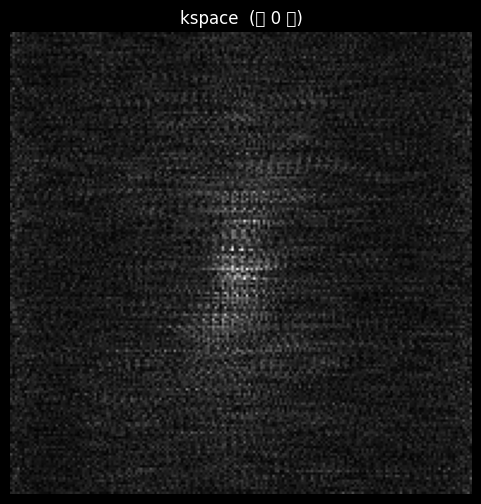

findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Fon

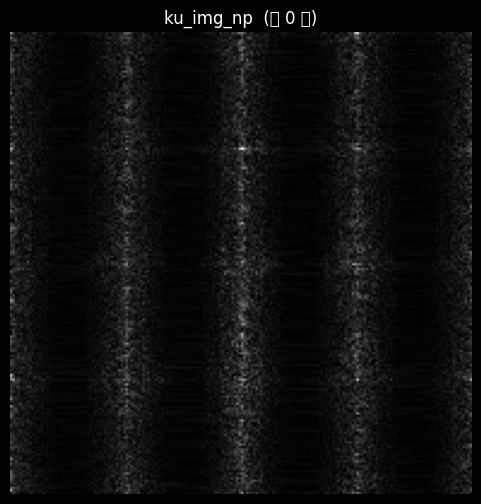

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# # 设置中文字体
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
# data_path = '/opt/data/private/zhiyong/code/github/itzzy_git/k_gin_base/front_output/kgin_front_data_inference_2.npz'
data_path = './front_output/kgin_front_data_inference_0222_r8.npz'
data = np.load(data_path)
# image = data['image_recon']  # (1, 18, 192, 192)
kspace = data['kspace_recon']
# print('kspace-shape:',kspace.shape) #kspace-shape: (1, 18, 192, 192)
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(kspace[0,0,:,:]), cmap='gray')  # 使用灰度颜色映射
plt.title("kspace  (第 0 帧)")
plt.axis('off')
plt.show()

# 可视化第0帧图像
# plt.imshow(np.abs(image[0, 10]), cmap='gray')
# plt.title('Reconstructed Frame 0')
# plt.axis('off')
# plt.show()

ku_img = IFFT2c(kspace)
ku_img_np = np.abs(ku_img)
plt.figure(figsize=(6, 6))
plt.imshow(ku_img_np[0,0,:,:], cmap='gray')  # 使用灰度颜色映射
plt.title("ku_img_np  (第 0 帧)")
plt.axis('off')
plt.show()
